# Sistema de recomendación: caso Netflix
Objetivo: construir un sistema de recomendación de películas basado en los datos de Netflix.

Los pasos a seguir son:
* Análisis de datos
* Pre-procesamiento
* Construcción del sistema de recomendación
    - Usando filtrado colaborativo

[Fuente de datos](https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation/data)

In [ ]:
#Importamos las libretass que vamos a ocupar
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Cargamos los datos
df1 = pd.read_csv('/content/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])


Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [ ]:
df_raiting = df1[:500000] #selección de sub-conjunto de registros
df_raiting.head(5)

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [ ]:
print('Tamaño de la base de datos: {}'.format(df_raiting.shape))

Tamaño de la base de datos: (500000, 2)


## Análisis de datos

In [ ]:
print("Conteo de raitings")
p = df_raiting.groupby('Rating')['Rating'].agg(['count'])
print(p)

Conteo de raitings
         count
Rating        
1.0      25316
2.0      52325
3.0     147151
4.0     174248
5.0     100812


In [ ]:
movie_count = df_raiting.isnull().sum()[1]#Se obtiene el total de películas
users_count = df_raiting['Cust_Id'].nunique() - movie_count#Se obtiene el total de usuarios
rating_count = df_raiting['Cust_Id'].count() - movie_count#Se obtiene el total de ratings

print("Total de películas:", movie_count, "total de usuarios:", users_count, "total de ratings:", rating_count)

Total de películas: 148 total de usuarios: 214992 total de ratings: 499852


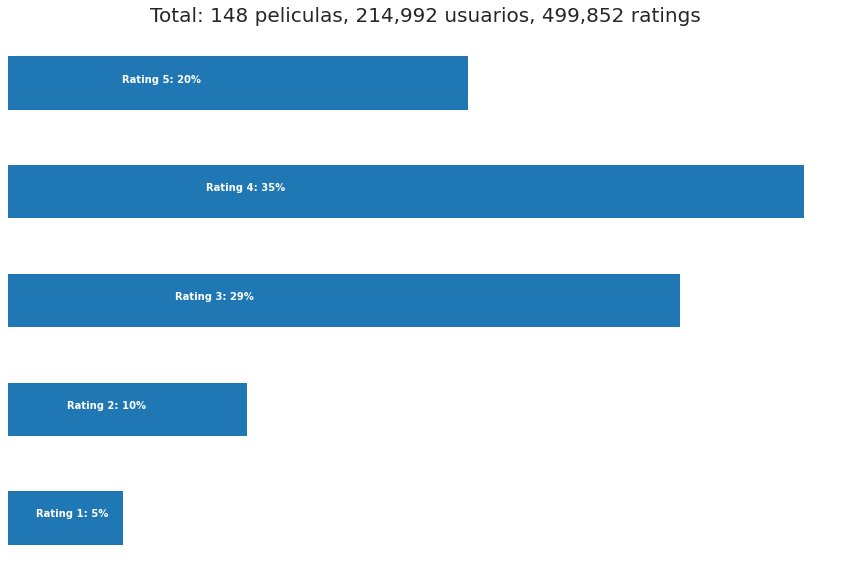

In [ ]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total: {:,} peliculas, {:,} usuarios, {:,} ratings'.format(movie_count, users_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

Se observa que la mayoría de los ratings tiende a ser positiva (>3)

## Carga del catálogo de películas

In [ ]:
"""Crear una matriz para el ID de la película (procesamiento más eficiente)"""
df_nan = pd.DataFrame(pd.isnull(df_raiting.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

print("Tamaño df_nan:", df_nan.shape)
df_nan.head(10)

Tamaño df_nan: (148, 2)


,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
5,3991,True
6,5011,True
7,5105,True
8,20016,True
9,20112,True


In [ ]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id) #Return a new array of given shape and type, filled with movie_id
    movie_np = np.append(movie_np, temp)
    movie_id += 1

In [ ]:
# Se toma en cuenta el último registro y la longitud correspondiente
last_record = np.full((1,len(df_raiting) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record) #indices de las películas

print('Películas (numpy): {}'.format(movie_np))

Películas (numpy): [  1.   1.   1. ... 148. 148. 148.]


In [ ]:
"""Visualizamos nuevamente"""
df_raiting = df_raiting[pd.notnull(df_raiting['Rating'])]

df_raiting['Movie_Id'] = movie_np.astype(int)
df_raiting['Cust_Id'] = df_raiting['Cust_Id'].astype(int)
df_raiting

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
499995,1957556,4.0,148
499996,1492198,3.0,148
499997,1018901,3.0,148
499998,213704,4.0,148


In [ ]:
"""Carga de la base de datos de películas"""
df_movies = pd.read_csv('/content/movie_titles.csv', 
                        encoding = "ISO-8859-1", header = None, 
                        names = ['Movie_Id', 'Year', 'Name'])
df_movies.set_index('Movie_Id', inplace = True)
print (df_movies.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


Para no hacer tan grande la matriz de peliculas con los usuarios vamos aeliminar aquellos usuarios los cuales no tengan una gran actividad de la misma forma para las  peliculas que no sean vistas mucho, por lo que eliminaremos el primer quartil de ambos rubros.

In [ ]:
f = ['count','mean']
df_movie_summary = df_raiting.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary=df_movie_summary.sort_values(by='count',ascending=False)
df_movie_summary.head()

,count,mean
Movie_Id,,
30,118413,3.761842
28,39752,3.823254
143,38362,3.853032
111,30127,3.082882
118,19240,3.432952


In [ ]:
df_movie_summary = df_movie_summary.head(111)
print(df_movie_summary.shape)
df_movie_summary.head()

(111, 2)


,count,mean
Movie_Id,,
30,118413,3.761842
28,39752,3.823254
143,38362,3.853032
111,30127,3.082882
118,19240,3.432952


In [ ]:
df_cust_summary = df_raiting.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary=df_cust_summary.sort_values(by='count',ascending=False)
print(df_cust_summary.shape)
df_cust_summary.head()

(214992, 2)


,count,mean
Cust_Id,,
305344,143,1.713287
387418,143,1.685315
2439493,140,1.192857
1664010,127,4.149606
2118461,117,4.000000


In [ ]:
df_cust_summary = df_cust_summary.head(int((3*214992)/4))
print(df_cust_summary.shape)
df_cust_summary.head()

(161244, 2)


,count,mean
Cust_Id,,
305344,143,1.713287
387418,143,1.685315
2439493,140,1.192857
1664010,127,4.149606
2118461,117,4.000000


In [ ]:
movies = df_movies.copy() 
movies = movies.reset_index()
movies = movies[~movies['Movie_Id'].isin(df_movie_summary)]
df_movies.shape

(17770, 2)

In [ ]:
"""Entrenar el modelo"""
from surprise.model_selection import train_test_split
from surprise import accuracy

reader = Reader()
data = Dataset.load_from_df(df_raiting[['Cust_Id', 'Movie_Id', 'Rating']], reader) #Traemos la base de datos completa

trainset, testset = train_test_split(data, test_size=.25)
svd = SVD() #definición del modelo
trainset = data.build_full_trainset()
svd.fit(trainset) #training

print("Rendimiento sobre conjunto de prueba")
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

Rendimiento sobre conjunto de prueba
RMSE: 0.7254
0.7254345059396833


Ahora vamos a analizar a usuarios en particular para recomendarles alguna pelicula

In [ ]:
id1= 305344 
id2= 2118461 
def recomendacion(id,movies=movies):
  user = df_raiting[(df_raiting['Cust_Id'] == id) & (df_raiting['Rating'] == 5)]
  user = user.set_index('Movie_Id')
  user = user.join(df_movies)['Name']
  print("Películas que ha visto el usuario "+str(id))
  print(user)
  movies['Estimate_Score'] = movies['Movie_Id'].apply(lambda x: svd.predict(id, x).est)
  movies = movies.sort_values('Estimate_Score', ascending=False)
  print('Te recomendamos las siguientes peliculas')
  return(movies.head(5))


In [ ]:
recomendacion(id1)

Películas que ha visto el usuario 305344
Movie_Id
15    Neil Diamond: Greatest Hits Live
83                            Silkwood
Name: Name, dtype: object
Te recomendamos las siguientes peliculas


,Movie_Id,Year,Name,Estimate_Score
14,15,1988.0,Neil Diamond: Greatest Hits Live,3.577938
12,13,2003.0,Lord of the Rings: The Return of the King: Ext...,3.044011
48,49,2003.0,Devo: The Complete Truth About De-evolution,3.006520
142,143,1997.0,The Game,2.927967
54,55,1995.0,Jade,2.891731


In [ ]:
recomendacion(id2)

Películas que ha visto el usuario 2118461
Movie_Id
1                                        Dinosaur Planet
5                               The Rise and Fall of ECW
13     Lord of the Rings: The Return of the King: Ext...
16                                             Screamers
23     Clifford: Clifford Saves the Day! / Clifford's...
25         Inspector Morse 31: Death Is Now My Neighbour
27     Sesame Street: Elmo's World: The Street We Liv...
28                                       Lilo and Stitch
30                                Something's Gotta Give
32     ABC Primetime: Mel Gibson's The Passion of the...
33                        Aqua Teen Hunger Force: Vol. 1
35                       Ferngully 2: The Magical Rescue
37                                 Zatoichi's Conspiracy
48                                        Justice League
52                               The Weather Underground
55                                                  Jade
56                                   

,Movie_Id,Year,Name,Estimate_Score
134,135,1998.0,GTO: Great Teacher Onizuka: Set 2,5.0
57,58,1996.0,Dragonheart,5.0
67,68,2004.0,Invader Zim,5.0
32,33,2000.0,Aqua Teen Hunger Force: Vol. 1,5.0
31,32,2004.0,ABC Primetime: Mel Gibson's The Passion of the...,5.0


## Construcción del sistema de recomendación usando filtrado colaborativo

Construye un sistema de recomendació, usando filtrado colaborativo.

Tip: puedes usar la biblioteca [Surprise](https://surprise.readthedocs.io/en/stable/getting_started.html) y emplear el algoritmo de [factorización de matrices probabilísticas](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD).